In [18]:
import pandas as pd
from aerobot.io import load_training_data, load_validation_data
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier
import seaborn as sns

print("Loading data...")

#feature_type = "embedding.genome"
#kmer = 3
#feature_type = f"aa_{kmer}mer"
feature_type = "nt_5mer"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)
cleaned_data = process_data(training_data["features"], training_data["labels"]["physiology"], validation_data["features"], validation_data["labels"]["physiology"])
only_cononical_nts = [x for x in cleaned_data["column_labels"] if len(set(x) - set(["A","C","G","T"])) == 0]
columns_to_keep = [x in only_cononical_nts for x in cleaned_data["column_labels"]]
cleaned_data["X_train"] = cleaned_data["X_train"][:,columns_to_keep]
cleaned_data["X_test"] = cleaned_data["X_test"][:,columns_to_keep]
cleaned_data["column_labels"] = [x for x in cleaned_data["column_labels"] if x in only_cononical_nts]


Loading data...


In [18]:
import pandas as pd
from aerobot.io import load_training_data, load_validation_data
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier
import seaborn as sns

print("Loading data...")

feature_type = "nt_4mer"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)
# convert labels to two classes (change Facultative to Aerobe)
#training_data["labels"]["physiology"] = training_data["labels"]["physiology"].replace("Facultative", "Aerobe")
#validation_data["labels"]["physiology"] = validation_data["labels"]["physiology"].replace("Facultative", "Aerobe")
cleaned_data = process_data(training_data["features"], training_data["labels"]["physiology"], validation_data["features"], validation_data["labels"]["physiology"])


Loading data...


In [20]:
print("Fitting model...")
model = LogisticClassifier(max_iter=100000,normalize=True,random_state=None)
model.fit(cleaned_data["X_train"], cleaned_data["y_train"])
accuracy = model.score(cleaned_data["X_train"], cleaned_data["y_train"])
# balanced accuracy
balanced_accuracy = model.balanced_accuracy(cleaned_data["X_train"], cleaned_data["y_train"])
#print accuracy and balanced accuracy
print("Accuracy: " + str(accuracy))
print("Balanced Accuracy: " + str(balanced_accuracy))

# compute accuracy and balanced accuracy on test set
test_accuracy = model.score(cleaned_data["X_test"], cleaned_data["y_test"])
test_balanced_accuracy = model.balanced_accuracy(cleaned_data["X_test"], cleaned_data["y_test"])
print("Test Accuracy: " + str(test_accuracy))
print("Test Balanced Accuracy: " + str(test_balanced_accuracy))


Fitting model...


/Users/joshuagoldford/opt/miniconda3/envs/aerobot/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joshuagoldford/opt/miniconda3/envs/aerobot/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

KeyboardInterrupt: 

In [17]:
pd.DataFrame({"feature": cleaned_data["column_labels"],"classifier": model.classifier.coef_[0]}).sort_values("classifier")

,feature,classifier
16,R,-2.679817
0,T,-2.307193
15,M,-1.841049
13,Y,-1.638596
7,L,-1.389634
17,K,-1.337674
19,C,-1.257192
9,V,-0.526866
1,A,-0.296399
11,Q,-0.193739


In [12]:
model.classifier.coef_[0]

array([ 2.94733226, -3.42246645, -0.09591742, -3.55407618, -1.1958855 ,
       -0.98051844,  1.21122623, -0.38530672,  0.47636783, -0.89159138,
       -3.33099115,  1.75160493, -0.35817813,  2.906923  , -3.24050019,
        2.52394423,  4.93388004,  2.63676745, -6.55460127,  3.36246429,
        0.35866174])

In [20]:
C = model.confusion_matrix(cleaned_data["X_train"], cleaned_data["y_train"])
C= pd.DataFrame(C,index=model.classifier.classes_,columns=model.classifier.classes_)
C.apply(lambda x: x/x.sum(),axis=1)

,Aerobe,Anaerobe,Facultative
Aerobe,0.937391,0.034783,0.027826
Anaerobe,0.085691,0.902662,0.011647
Facultative,0.382979,0.196217,0.420804


In [8]:
import os
import pandas as pd
import glob

# Define the root directory
root_dir = '/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/BlackSea_PRJNA649215/mags_black_sea/'

# Get a list of all .faa files under the root directory
file_paths = glob.glob(root_dir + '**/*.faa', recursive=True)

# Extract the genome ids from the file paths
genome_ids = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# Convert the data into a pandas dataframe
mags = pd.DataFrame({
    'Genome_ID': genome_ids,
    'File_Path': file_paths
})

file_mapper = mags.set_index("File_Path")["Genome_ID"].to_dict()



In [62]:
#cleaned_data["column_labels"]

In [74]:
aa_kmer = count_aa_kmers(mags.File_Path.tolist(),kmer)
aa_kmer = aa_kmer.T
aa_kmer.index = [file_mapper[x] for x in aa_kmer.index.tolist()]
aa_kmer = aa_kmer.reindex(columns=cleaned_data["column_labels"], fill_value=0)
labels = model.predict(aa_kmer)


/Users/joshuagoldford/opt/miniconda3/envs/aerobot/lib/python3.8/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [67]:
mag_fraction = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.MAGfraction.04Feb2023.csv",index_col=0)
metadata = pd.read_csv("/Users/joshuagoldford/Documents/work/research_projects/metals_metabolism/data/blackSea.metadata.csv",index_col=0)


In [76]:
z = pd.DataFrame(labels,index=aa_kmer.index,columns=["oxygen"])
z = z.join(mag_fraction).dropna(axis=0).fillna(0)
z = z.groupby("oxygen").sum().T
df = metadata.join(z)

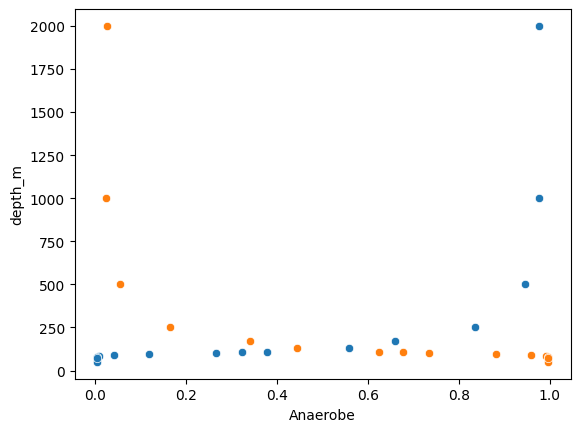

In [77]:
for label in list(set(labels)):
    sns.scatterplot(x=label,y="depth_m",data=df)
    #sns.lineplot(x=label,y="depth_m",data=df)



In [1]:
import pandas as pd
from aerobot.io import load_training_data, load_validation_data
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier
import seaborn as sns

print("Loading data...")

feature_type = "aa_2mer"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)
# convert labels to two classes (change Facultative to Aerobe)
training_data["labels"]["physiology"] = training_data["labels"]["physiology"].replace("Facultative", "Aerobe")
validation_data["labels"]["physiology"] = validation_data["labels"]["physiology"].replace("Facultative", "Aerobe")
cleaned_data = process_data(training_data["features"], training_data["labels"]["physiology"], validation_data["features"], validation_data["labels"]["physiology"])

Loading data...


In [11]:
from sklearn.linear_model import LogisticRegression
from aerobot.models import GeneralClassifier


# Initialize the GeneralClassifier with LogisticRegression having L2 penalty (default for LogisticRegression)
model = GeneralClassifier(model_class=LogisticRegression, params={'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 10000})

# Hyperparameter optimization

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
best_params = clf.hyperparameter_optimization(cleaned_data["X_train"], cleaned_data["y_train"], param_grid)
print("Best parameters:", best_params)

# Fit the classifier with optimized parameters
model.fit(cleaned_data["X_train"], cleaned_data["y_train"])


accuracy = model.score(cleaned_data["X_train"], cleaned_data["y_train"])
# balanced accuracy
balanced_accuracy = model.balanced_accuracy(cleaned_data["X_train"], cleaned_data["y_train"])
#print accuracy and balanced accuracy
print("Accuracy: " + str(accuracy))
print("Balanced Accuracy: " + str(balanced_accuracy))

# compute accuracy and balanced accuracy on test set
test_accuracy = model.score(cleaned_data["X_test"], cleaned_data["y_test"])
test_balanced_accuracy = model.balanced_accuracy(cleaned_data["X_test"], cleaned_data["y_test"])
print("Test Accuracy: " + str(test_accuracy))
print("Test Balanced Accuracy: " + str(test_balanced_accuracy))



Best parameters: {'C': 1}
Accuracy: 0.9501492537313433
Balanced Accuracy: 0.9422571629531167
Test Accuracy: 0.8198529411764706
Test Balanced Accuracy: 0.8090142849324065


In [5]:

ko2ec = pd.read_csv("../assets/mappings/keggOrthogroupsToECnumbers.07Feb2023.csv",index_col=0)
oxygen_genes = pd.read_csv("../assets/mappings/ko_groups.oxygenAssociated.07Feb2023.csv",index_col=0)
oxygen_genes = oxygen_genes.KO.tolist()
ko2ec["EC"] = ko2ec["ec"].apply(lambda x: x.split(":")[1])
ko2ec["KO"] = ko2ec["ko"].apply(lambda x: x.split(":")[1])


gene_lists = {}
#terminal_oxidase_gfs = kegg.link("ko","md:M00154+md:M00155+md:M00417+md:M00416+md:M00156")["f2"].apply(lambda x: x.split(":")[1]).tolist()
gene_lists["terminal_oxidase"] = ['K02257', 'K02262', 'K02256', 'K02261', 'K02263', 'K02264', 'K02265', 'K02266', 'K02267', 'K02268', 'K02270', 'K02271', 'K02272', 'K02273', 'K02258', 'K02259', 'K02260', 'K02275', 'K02274', 'K02276', 'K15408', 'K02277', 'K02297', 'K02298', 'K02299', 'K02300', 'K02827', 'K02826', 'K02828', 'K02829', 'K00404', 'K00405', 'K15862', 'K00407', 'K00406']
gene_lists["oxygen_genes"] = oxygen_genes

ECs5 = ["ec:1.3.3.3","ec:1.14.13.180","ec:1.14.13.113","ec:1.14.19.1","ec:1.14.14.47"]
KO5 = [x.split(":")[1] for x in ko2ec[ko2ec.ec.isin(ECs5)].ko.tolist()]
gene_lists["5_gene"]  = KO5


In [10]:
pd.DataFrame(gene_lists["oxygen_genes"]).to_csv("../assets/gene_sets/oxygen_associated_genes.csv",index=False,header=False)
pd.DataFrame(gene_lists["terminal_oxidase"]).to_csv("../assets/gene_sets/terminal_oxidase_genes.csv",index=False,header=False)
pd.DataFrame(gene_lists["5_gene"]).to_csv("../assets/gene_sets/jablonska_five_genes.csv",index=False,header=False)